- Description of Notebook: This analysis compares the number of orthologs between banana and human using OMA, OrthoInspector, and best-bidirectional hit.
- Last updated: 8 Dec 2020
- By: Natasha Glover

# Setup

In [1]:
#import libraries
from omadb import Client
import requests
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

#seaborn options
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'}, font_scale=1.5)
sns.set_style('whitegrid')

# Human-Banana orthologs using OrthoInspector

*OrthoInspector is a software suite for inference of orthologous relationships between protein coding-genes and an online resource to access and query precomputed orthology databases.* https://lbgi.fr/orthoinspectorv3/

In [2]:
human_ncbi_taxid = str(9606)
banana_ncbi_taxid = str(214687)

In [3]:
#get all the banana genes with an ortholog in human
response = requests.get("http://lbgi.fr/orthoinspectorv3/api/Eukaryota/species/"+ banana_ncbi_taxid +\
                        "/orthologs/"+ human_ncbi_taxid)

#count the number of banana genes with a human ortholog
banana_genes_with_orthologs = response.json()

print("There are {} banana genes with a human ortholog.".format(len(banana_genes_with_orthologs.keys())))

#count the number of banana genes
banana_genome = requests.get("http://lbgi.fr/orthoinspectorv3/api/Eukaryota/species/214687/proteins").json()

print("There are {} total number of genes in banana.".format(len(banana_genome)))

#percentage of banana genes with a human ortholog
percentage = len(banana_genes_with_orthologs.keys())/len(banana_genome)*100
print("Using OrthoInspector, {:.0f}% of the banana genome's proteins have an ortholog in human.".format(percentage))


There are 7668 banana genes with a human ortholog.
There are 36440 total number of genes in banana.
Using OrthoInspector, 21% of the banana genome's proteins have an ortholog in human.


Same thing with human.

In [4]:
#get all the human genes with an ortholog in banana
response = requests.get("http://lbgi.fr/orthoinspectorv3/api/Eukaryota/species/"+ human_ncbi_taxid +\
                        "/orthologs/"+ banana_ncbi_taxid)

#count the number of human  genes with a banana ortholog
human_genes_with_orthologs = response.json()

print("There are {} human genes with a banana ortholog.".format(len(human_genes_with_orthologs.keys())))

#count the number of human genes
human_genome = requests.get("http://lbgi.fr/orthoinspectorv3/api/Eukaryota/species/"+ human_ncbi_taxid +"/proteins").json()

print("There are {} total number of genes in human.".format(len(human_genome)))

#percentage of human genes with a banana ortholog
percentage = len(human_genes_with_orthologs.keys())/len(human_genome)*100
print("Using OrthoInspector, {:.0f}% of the human genome's proteins have an ortholog in banana.".format(percentage))


There are 5058 human genes with a banana ortholog.
There are 21006 total number of genes in human.
Using OrthoInspector, 24% of the human genome's proteins have an ortholog in banana.


# Human-Banana orthologs using OMA

Here, I use PyOMADB, the user-friendly Python wrapper around the OMA REST API. You can install it with "pip install omadb" from the command line.

In [5]:
c = Client()

First, get the number of genes in the human and banana genomes:

In [6]:
#count number of genes in the human genome
human_genome = c.genomes.proteins("HUMAN").as_dataframe()
human_genome = human_genome[human_genome['is_main_isoform']==True]

print("There are {} total number of genes in human.".format(len(human_genome)))

There are 20159 total number of genes in human.


In [7]:
#count number of genes in the banana genome
banana_genome = c.genomes.proteins("MUSAM").as_dataframe()
banana_genome = banana_genome[banana_genome['is_main_isoform']==True]

print("There are {} total number of genes in banana.".format(len(banana_genome)))

There are 36439 total number of genes in banana.


Next, get the orthologs!

In [8]:
#get the pairwise orthologs between human and banana
human_banana_pairs = list(c.pairwise('HUMAN', 'MUSAM'))

Finally, compute the percentage of genes with an ortholog in each species:

In [9]:
#count the number and percent of human genes with an ortholog in banana

#take the set to get a unique list, as a given gene might have multiple orthologs
human_genes_with_orthologs = set([x['entry_1']['omaid'] for x in human_banana_pairs if x['entry_1']['is_main_isoform']==True])

human_percentage = len(human_genes_with_orthologs)/len(human_genome)* 100

print("Using OMA, {:.0f}% of the human genome's proteins have an ortholog in banana.".format(human_percentage), "\n")

Using OMA, 17% of the human genome's proteins have an ortholog in banana. 



In [10]:
#count the number and percent of banana genes with an ortholog in human

banana_genes_with_orthologs = set([x['entry_2']['omaid'] for x in human_banana_pairs if x['entry_2']['is_main_isoform']==True])

banana_percentage = len(banana_genes_with_orthologs)/len(banana_genome)* 100

print("Using OMA, {:.0f}% of the banana genome's proteins have an ortholog in human.".format(banana_percentage))

Using OMA, 14% of the banana genome's proteins have an ortholog in human.


# Human-banana orthologs using Best Bidirectional Hit

Update:
- Downloaded human genome from UniProt: ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000005640_9606.fasta.gz
- This reference proteome has 20609 genes, one representative protein per locus.

- Downloaded the banana genome from UniProt: ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/reference_proteomes/Eukaryota/UP000012960_214687.fasta.gz
- 36474 genes (1 protein sequence per gene)

Commands for running blast:
- source /dcsrsoft/spack/bin/setup_dcsrsoft
- module load gcc
- module load blast-plus/2.9.0
- makeblastdb -in human_genome.faa -dbtype prot
- makeblastdb -in banana_genome.faa -dbtype prot
- mkdir banana_input
- mkdir human_input
- pyfasta split -n 100 human_genome.faa
- mv human_genome.[0-9]*.faa human_input/
- pyfasta split -n 100 banana_genome.faa
- mv banana_genome.[0-9]*.faa banana_input/

The next part uses the SLURM script.
- sbatch blast_banana_vs_human.sh
- sbatch blast_human_vs_banana.sh

- cat banana_vs_human_output/* > banana_vs_human.blastp
- cat human_vs_banana_output/* > human_vs_banana.blastp


In [11]:
header = ["qseqid","sseqid","pident","length","mismatch","gapopen","qstart","qend","qlen", \
          "sstart","send","slen","evalue","bitscore"]
human_df = pd.read_csv("human_vs_banana.blastp", sep="\t", header=None)
human_df.columns = header
human_df = human_df.drop_duplicates(subset="qseqid", keep="first")
human_df.rename({"qseqid":"human_gene", "sseqid":"banana_gene"}, axis=1, inplace=True)
print(len(human_df))
      
human_df[:10]


10236


,human_gene,banana_gene,pident,length,mismatch,gapopen,qstart,qend,qlen,sstart,send,slen,evalue,bitscore
0,sp|Q8WZ42|TITIN_HUMAN,tr|M0TF21|M0TF21_MUSAM,30.847,295,190,5,32161,32444,34350,78,369,547,1.050000e-41,166.0
1,sp|Q9HAZ2|PRD16_HUMAN,tr|M0SGM7|M0SGM7_MUSAM,30.481,187,96,8,281,435,1276,40,224,224,1.040000e-09,60.1
2,sp|P49796|RGS3_HUMAN,tr|M0S195|M0S195_MUSAM,35.135,74,40,3,152,224,1198,3,69,181,4.030000e-04,42.7
3,sp|Q5T5C0|STXB5_HUMAN,tr|M0T2E9|M0T2E9_MUSAM,29.412,119,81,2,51,169,1151,27,142,1140,1.050000e-11,69.3
4,sp|O75717|WDHD1_HUMAN,tr|M0S167|M0S167_MUSAM,27.638,796,500,25,54,815,1129,140,893,925,2.850000e-85,296.0
5,sp|Q02846|GUC2D_HUMAN,tr|M0RVB0|M0RVB0_MUSAM,29.457,258,144,9,578,825,1103,445,674,692,1.330000e-21,100.0
6,sp|Q05469|LIPS_HUMAN,tr|M0SHK9|M0SHK9_MUSAM,34.646,127,73,4,635,755,1076,101,223,306,2.110000e-11,66.2
7,sp|Q70EK8|UBP53_HUMAN,tr|M0S5N6|M0S5N6_MUSAM,33.146,178,99,5,31,189,1073,1117,1293,1309,3.880000e-18,90.5
8,sp|Q03701|CEBPZ_HUMAN,tr|M0SAD2|M0SAD2_MUSAM,33.539,647,340,12,224,818,1054,182,790,961,2.180000e-102,343.0
9,sp|Q96P70|IPO9_HUMAN,tr|M0SDG9|M0SDG9_MUSAM,28.402,926,632,15,16,930,1041,3,908,1023,1.250000e-120,394.0


In [12]:
banana_df = pd.read_csv("banana_vs_human.blastp", sep="\t", header=None)
banana_df.columns = header
banana_df = banana_df.drop_duplicates(subset="qseqid", keep="first")
banana_df.rename({"qseqid":"banana_gene", "sseqid":"human_gene"}, axis=1, inplace=True)
print(len(banana_df))
banana_df[:10]

17535


,banana_gene,human_gene,pident,length,mismatch,gapopen,qstart,qend,qlen,sstart,send,slen,evalue,bitscore
0,tr|M0TA06|M0TA06_MUSAM,sp|Q9BYJ1|LOXE3_HUMAN,31.193,327,187,7,318,639,12011,250,543,711,3.550000e-31,135.0
1,tr|M0SYJ7|M0SYJ7_MUSAM,sp|P62750|RL23A_HUMAN,82.857,70,12,0,1,70,70,87,156,156,3.360000e-35,115.0
2,tr|M0SQ12|M0SQ12_MUSAM,sp|P07108|ACBP_HUMAN,51.948,77,37,0,6,82,90,5,81,87,2.210000e-23,84.7
3,tr|M0TYT7|M0TYT7_MUSAM,sp|P53567|CEBPG_HUMAN,35.484,62,36,2,6,64,93,61,121,150,1.000000e-03,35.8
4,tr|M0TL36|M0TL36_MUSAM,sp|Q15370|ELOB_HUMAN,29.670,91,54,3,1,84,94,3,90,118,5.250000e-06,41.2
5,tr|M0T8W6|M0T8W6_MUSAM,sp|Q96CD2|COAC_HUMAN,34.722,72,43,1,21,92,100,20,87,204,6.680000e-06,42.4
6,tr|M0T428|M0T428_MUSAM,sp|P0DP25|CALM3_HUMAN,41.667,60,35,0,31,90,108,10,69,149,4.330000e-06,42.4
7,tr|M0T4Z9|M0T4Z9_MUSAM,sp|O00244|ATOX1_HUMAN,41.935,62,35,1,36,97,112,8,68,68,9.900000e-10,50.4
8,tr|M0SYU4|M0SYU4_MUSAM,sp|P46778|RL21_HUMAN,48.148,108,54,1,1,106,113,52,159,160,9.780000e-31,106.0
9,tr|M0T6U9|M0T6U9_MUSAM,sp|Q8IZL9|CDK20_HUMAN,26.190,126,47,1,2,81,125,180,305,346,5.010000e-07,46.6


In [13]:
bbh_df = pd.merge(left=human_df, right=banana_df, on=['human_gene', 'banana_gene'], how="inner")
bbh_df[:5]

,human_gene,banana_gene,pident_x,length_x,mismatch_x,gapopen_x,qstart_x,qend_x,qlen_x,sstart_x,...,mismatch_y,gapopen_y,qstart_y,qend_y,qlen_y,sstart_y,send_y,slen_y,evalue_y,bitscore_y
0,sp|O75717|WDHD1_HUMAN,tr|M0S167|M0S167_MUSAM,27.638,796,500,25,54,815,1129,140,...,507,25,140,891,925,54,813,1129,2.070000e-79,280.0
1,sp|Q03701|CEBPZ_HUMAN,tr|M0SAD2|M0SAD2_MUSAM,33.539,647,340,12,224,818,1054,182,...,433,21,161,929,961,201,954,1054,5.820000e-112,369.0
2,sp|Q96P70|IPO9_HUMAN,tr|M0SDG9|M0SDG9_MUSAM,28.402,926,632,15,16,930,1041,3,...,719,17,3,1020,1023,16,1039,1041,9.090000e-127,410.0
3,sp|Q96RT8|GCP5_HUMAN,tr|M0SQE0|M0SQE0_MUSAM,27.348,362,205,9,685,1014,1024,640,...,205,9,640,975,1012,685,1014,1024,4.610000e-30,128.0
4,sp|Q6ZNA4|RN111_HUMAN,tr|M0SLH6|M0SLH6_MUSAM,35.772,123,54,3,869,983,994,36,...,57,2,36,141,147,869,983,994,5.330000e-16,73.6


In [14]:
nb_bbhs = len(bbh_df)
nb_human_genes_uniprot = 20609
nb_banana_genes_uniprot = 36474
print("There are {} genes in the uniprot reference human proteome."\
      .format(nb_human_genes_uniprot))
print("There are {} genes in the uniprot reference banana proteome."\
      .format(nb_banana_genes_uniprot))
print("There are {} best bidirectional hits between human and banana."\
      .format(nb_bbhs))
print("This is {:.0f}% of the human genome, and {:.0f}% of the banana genome."\
      .format(nb_bbhs/nb_human_genes_uniprot*100, nb_bbhs/nb_banana_genes_uniprot*100))

There are 20609 genes in the uniprot reference human proteome.
There are 36474 genes in the uniprot reference banana proteome.
There are 3598 best bidirectional hits between human and banana.
This is 17% of the human genome, and 10% of the banana genome.


# Summary

<AxesSubplot:xlabel='method', ylabel='% of genome shared with the other'>

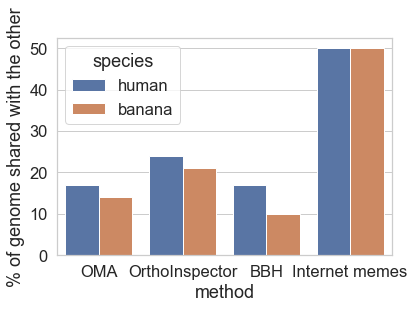

In [15]:
summary_df = pd.DataFrame(data={"method": ["OMA","OrthoInspector","BBH","Internet memes"], "human": [17,24,17,50], \
                                "banana":[14,21,10,50]})
df = pd.melt(summary_df, id_vars="method", value_vars=["human", "banana"])
df.rename({"variable":"species", "value": "% of genome shared with the other"}, axis=1, inplace=True)

sns.barplot(x="method", y="% of genome shared with the other", data=df, hue="species")

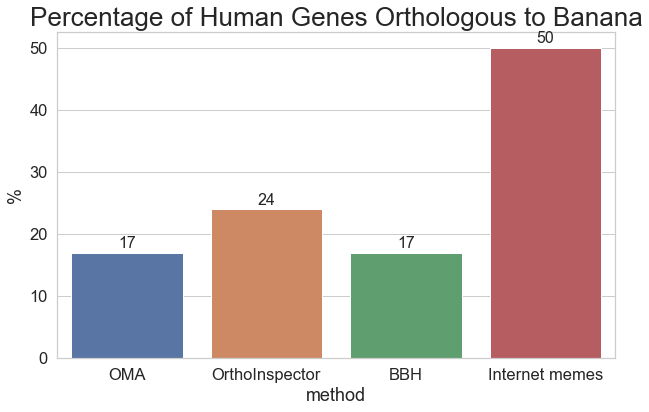

In [16]:
plt.figure(figsize=(10,6))
myplot = sns.barplot(x="method", y="human", data=summary_df)
for p in myplot.patches:
    myplot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   size = 16,
                   textcoords = 'offset points')
plt.title("Percentage of Human Genes Orthologous to Banana", size=26)
plt.ylabel("%")
plt.savefig('./Percentage_human_banana_orthologs_barplot.pdf')

# Bonus! GO enrichment

So what are the functions of the human-banana orthologs? We can find out by doing a Gene Ontology (GO) enrichment analysis. 

To do this, I will get the canonical ID of each human gene with an ortholog and use this as the "study set" for a GOEA using the [panther tool](http://pantherdb.org/webservices/go/overrep.jsp).  

In [17]:
#write file for upload to go enrichment tool
canonical_ids = human_genome[human_genome['omaid'].isin(human_genes_with_orthologs)]['canonicalid']

with open("human_orthologs_for_go_enrichment.txt", "w") as outfile:
    for humanid in canonical_ids:
        outfile.write(humanid + "\n")

Use the list of genes in the previous step to upload to the online go enrichment webserver. The following code works on the resulting table file, which I named "GOanalysis.txt."

In [18]:
go_df = pd.read_csv("./GOanalysis.txt", sep="\t", skiprows=11)

#do some manipulation to get the go term and the p-value of enriched terms
go_df['go_term'] = go_df['GO biological process complete'].apply(lambda x: x.split("(")[-1])
go_df['go_term'] = go_df['go_term'].apply(lambda x: x.split(")")[0])
go_df = go_df[go_df['go_term'].str.contains("GO")]

#print for revigo
#print(go_df[['go_term','human_orthologs_for_go_enrichment.txt (FDR)']].to_string(index=False, justify="left"))

#write to file
go_df[['go_term', 'human_orthologs_for_go_enrichment.txt (FDR)']].to_csv("./enrichedGOterms_bonferroni.tsv", sep="\t", \
                                                                         index=False, header=False)

Summarize and visualize the resulting list of enriched GO terms with GO-Figure! https://www.biorxiv.org/content/10.1101/2020.12.02.408534v1.full.pdf

In [19]:
%%bash
python ~/Applications/GO-Figure/gofigure.py -i ~/DessimozRepos/blogpost-code/enrichedGOterms.tsv \
-o gofigure/ --legend full --title "Enriched GO terms for human-banana orthologs" --cluster_labels description-numbered

Starting calculations

Calculating biological process
Output for biological processfound in: gofigure//biological_process_gofigure_.png

Calculating molecular function
No GO terms for ontology found: molecular_function

Calculating cellular component
No GO terms for ontology found: cellular_component
Finished!
